# Predicting House Prices - PyCon 2017

#### Load required libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_data = pd.read_csv('data/kc_house_data.csv')

## 1. Exploratory Data Analysis

Get to know the dataset and buid an intuitive sense of it

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
df_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,7129300520,20141013T000000,221900,3,1.00,1180.00,5650,1.00,0,0,3,7,1180,0,1955.00,nan,98178.00,47.51,-122.26
1,6414100192,20141209T000000,538000,3,2.25,2570.00,7242,2.00,0,0,3,7,2170,400,1951.00,1991.00,98125.00,47.72,-122.32
2,5631500400,20150225T000000,180000,2,1.00,770.00,10000,1.00,0,0,3,6,770,0,1933.00,nan,98028.00,47.74,-122.23
3,2487200875,20141209T000000,604000,4,3.00,1960.00,5000,1.00,0,0,5,7,1050,910,1965.00,nan,98136.00,47.52,-122.39
4,1954400510,20150218T000000,510000,3,2.00,1680.00,8080,1.00,0,0,3,8,1680,0,1987.00,nan,98074.00,47.62,-122.05


In [5]:
lst_cols = list(df_data.columns)
print('The dataset contains %s columns' % len(lst_cols))
lst_cols

The dataset contains 19 columns


['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long']

In [6]:
df_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
count,21613.00,21613.00,21613.00,21613.00,21605.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21607.00,914.00,21609.00,21613.00,21613.00
mean,4580301520.86,540088.14,3.37,2.11,2079.94,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,1995.83,98077.94,47.56,-122.21
std,2876565571.31,367127.20,0.93,0.77,918.51,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,15.52,53.51,0.14,0.14
min,1000102.00,75000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,1934.00,98001.00,47.16,-122.52
25%,2123049194.00,321950.00,3.00,1.75,1430.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,1987.00,98033.00,47.47,-122.33
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,2000.00,98065.00,47.57,-122.23
75%,7308900445.00,645000.00,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,2007.00,98118.00,47.68,-122.12
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31


#### List down unique values

In [7]:
lst_interesting_features = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

for feature in lst_interesting_features:
    print('%s : %s' %( feature, ','.join(map(str, sorted(df_data[feature].unique())))))

bedrooms : 0,1,2,3,4,5,6,7,8,9,10,11,33
bathrooms : 0.0,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,3.75,4.0,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5,6.75,7.5,7.75,8.0
floors : 1.0,1.5,2.0,2.5,3.0,3.5
waterfront : 0,1
view : 0,1,2,3,4
condition : 1,2,3,4,5
grade : 1,3,4,5,6,7,8,9,10,11,12,13


**Some Observations and Questions**
    - Can a house have no bedrooms or no bathrooms?
    - does id and date provide any useful information
    - Can we have decimal values in bathroom and floor?
    - should waterfront, view, condition and grade be categorical features?
    - How do we incorporate location information (zipcode, lat, long) in the model?
    - Can we engineer more useful features from these base features?

#### Observe the distribution of numerical features

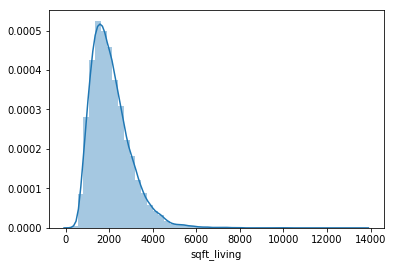

In [8]:
sns.distplot(df_data['sqft_living'].dropna())

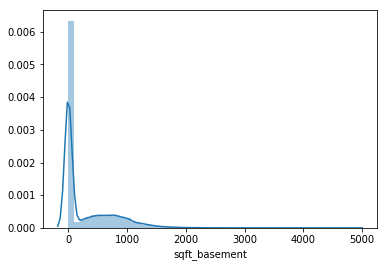

In [9]:
sns.distplot(df_data['sqft_basement'].dropna())

#### Observe the distribution of categorical variables

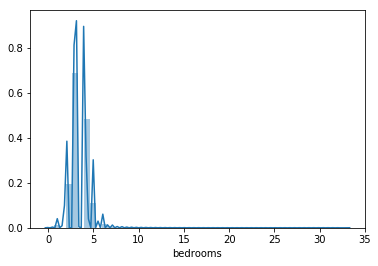

In [10]:
sns.distplot(df_data['bedrooms'].dropna())

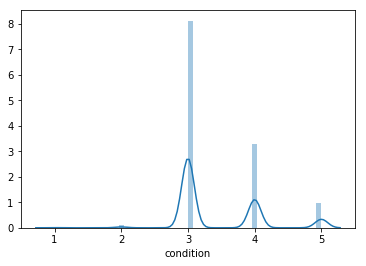

In [11]:
sns.distplot(df_data['condition'].dropna())

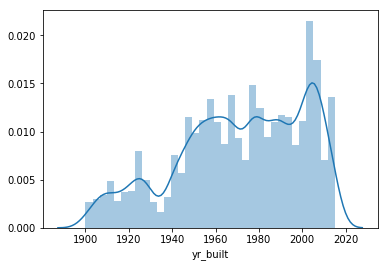

In [12]:
sns.distplot(df_data['yr_built'].dropna())

#### Observe the distribution of target variable

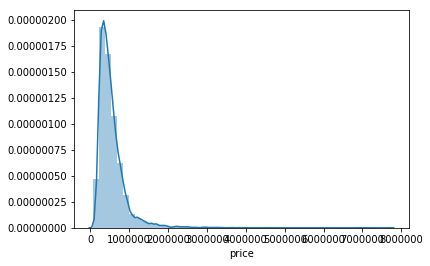

In [13]:
sns.distplot(df_data['price'])

#### Relationship with numerical features

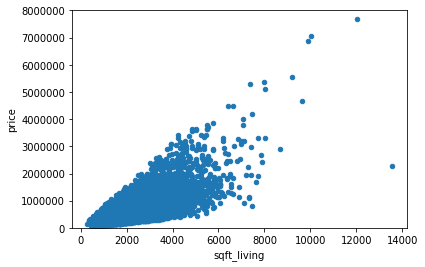

In [14]:
var = 'sqft_living'
data = pd.concat([df_data['price'], df_data[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,8000000))

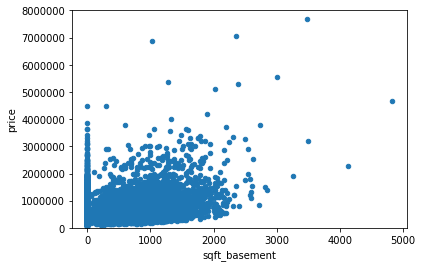

In [15]:
var = 'sqft_basement'
data = pd.concat([df_data['price'], df_data[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(0,8000000))

#### Relationship with categorical features

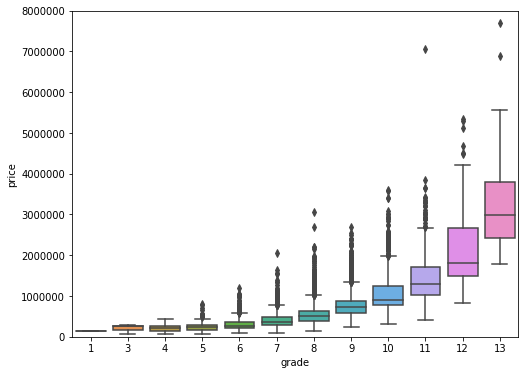

In [16]:
var = 'grade'
data = pd.concat([df_data['price'], df_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=8000000);

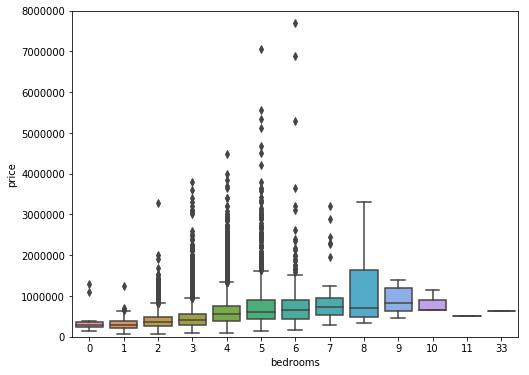

In [17]:
var = 'bedrooms'
data = pd.concat([df_data['price'], df_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=8000000);

#### Check the correlation matrix

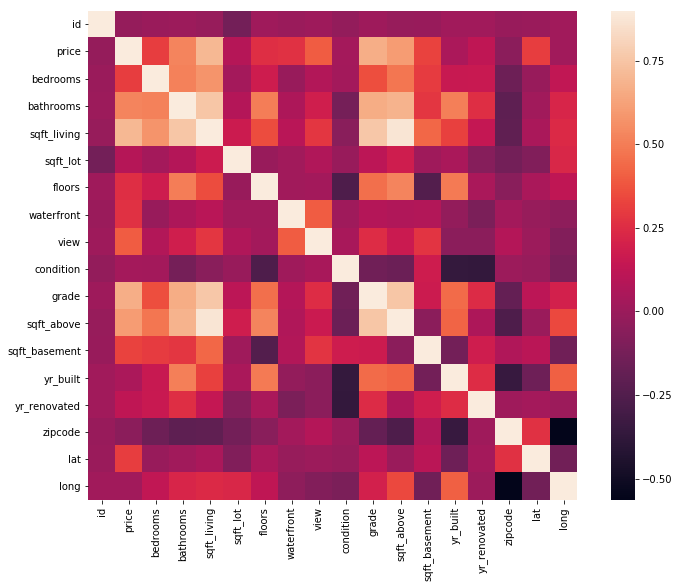

In [18]:
corrmat = df_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9, square=True)

sqft_living is a sum of sqft_above and sqft_basement, therefore sqft_living is strongly correlated to sqft_above

## 2. Data Cleaning

#### Remove duplicate observations

In [19]:
df_cols = [col for col in df_data.columns if col not in ['id', 'date']]
df_cols

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long']

In [20]:
print('No. of observations before removing duplicates: %s' % len(df_data))
df_data = df_data.drop_duplicates(subset=df_cols, keep='first')
print('No. of observations after removing duplicates: %s' % len(df_data))

No. of observations before removing duplicates: 21613
No. of observations after removing duplicates: 21608


#### Remove faulty observations

In [21]:
print('No. of observations before filtering faulty observations: %s' % len(df_data))
df_data = df_data[(df_data.bedrooms != 0) & (df_data.bathrooms != 0)]
print('No. of observations after filtering faulty observations: %s' % len(df_data))

No. of observations before filtering faulty observations: 21608
No. of observations after filtering faulty observations: 21592


#### Remove outliers

In [22]:
print('No. of observations before removing outliers: %s' % len(df_data))
df_data = df_data[np.abs(df_data.price - df_data.price.mean()) <= (3 * df_data.price.std())]
print('No. of observations after removing outliers: %s' % len(df_data))

No. of observations before removing outliers: 21592
No. of observations after removing outliers: 21186


#### Identify and fix Missing Data

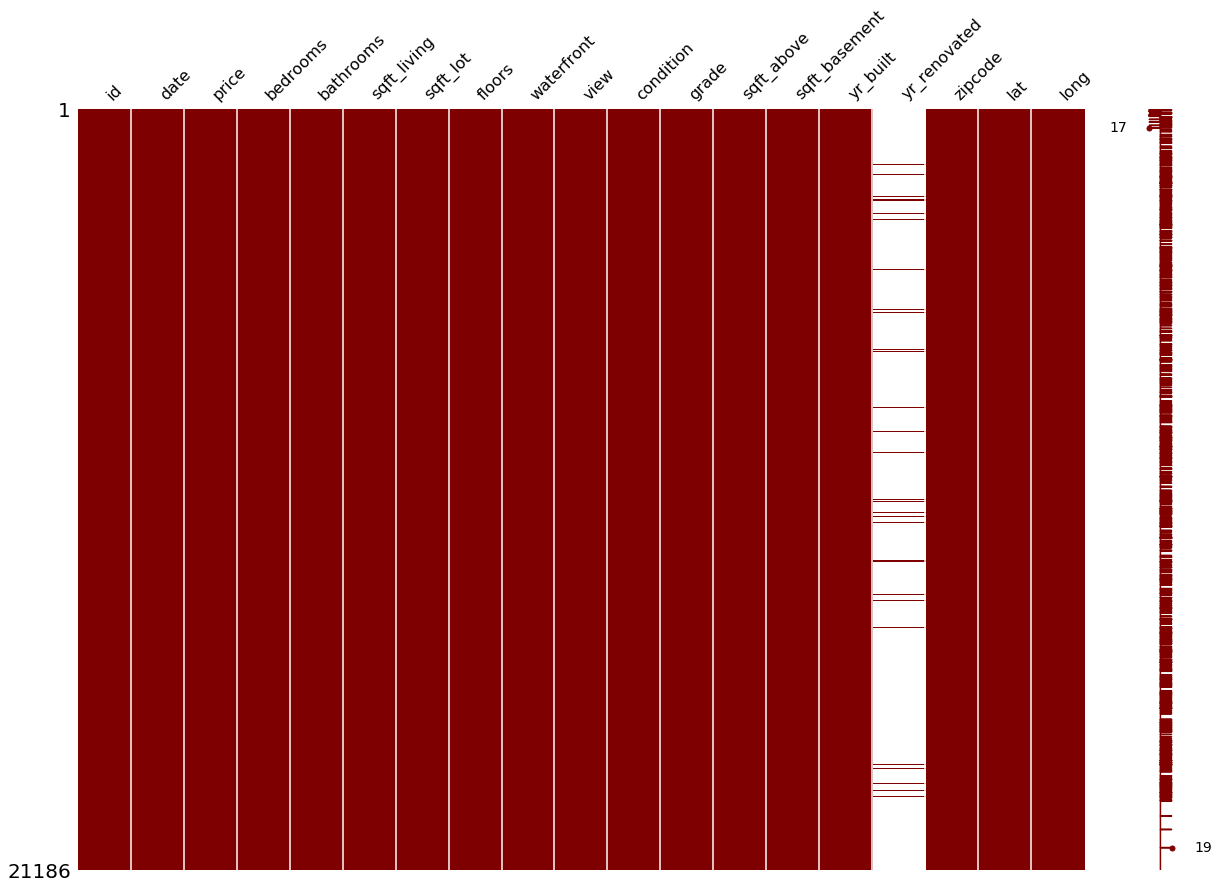

In [23]:
import missingno as msno
msno.matrix(df=df_data, figsize=(20,14), color=(0.5,0,0))

In [24]:
total = df_data.isnull().sum().sort_values(ascending=False)
percent = (df_data.isnull().sum() / df_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total > 0]

,Total,Percent
yr_renovated,20336,0.96
sqft_living,8,0.00
yr_built,6,0.00
zipcode,4,0.00


Its plausible to say that sqft_living, yr_built and zipcode cannot have missing values but the same cannot be said for yr_renovated

In [25]:
print('No. of observations before removing missing values: %s' % len(df_data))
df_data = df_data.dropna(subset = ['sqft_living', 'yr_built', 'zipcode'])
print('No. of observations after removing missing values: %s' % len(df_data))

No. of observations before removing missing values: 21186
No. of observations after removing missing values: 21168


For yr_renovated, we will fill the nan values with yr_built, the reason will become evident when we derive a new feature from it

In [26]:
df_data['yr_renovated'] = df_data['yr_renovated'].fillna(df_data['yr_built'])

## 3. Feature Engineering and Feature Selection

In [27]:
list(df_data.columns)

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long']

#### remove unwanted features

In [28]:
lst_selected_cols = [col for col in df_data.columns if col not in ['id', 'date', 'sqft_living', 'lat', 'long']]
lst_selected_cols

['price',
 'bedrooms',
 'bathrooms',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode']

In [29]:
df_data = df_data[lst_selected_cols]
df_data.head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode
0,221900,3,1.00,5650,1.00,0,0,3,7,1180,0,1955.00,1955.00,98178.00
1,538000,3,2.25,7242,2.00,0,0,3,7,2170,400,1951.00,1991.00,98125.00
2,180000,2,1.00,10000,1.00,0,0,3,6,770,0,1933.00,1933.00,98028.00
3,604000,4,3.00,5000,1.00,0,0,5,7,1050,910,1965.00,1965.00,98136.00
4,510000,3,2.00,8080,1.00,0,0,3,8,1680,0,1987.00,1987.00,98074.00


#### Can we derive better features from yr_built and yr_renovated?

In [30]:
from datetime import datetime
df_data['built_age'] = df_data['yr_built'].apply(lambda x: datetime.now().year - int(x))
df_data['renovation_age'] = df_data['yr_renovated'].apply(lambda x: datetime.now().year - int(x))

In [31]:
df_data.head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,built_age,renovation_age
0,221900,3,1.00,5650,1.00,0,0,3,7,1180,0,1955.00,1955.00,98178.00,62,62
1,538000,3,2.25,7242,2.00,0,0,3,7,2170,400,1951.00,1991.00,98125.00,66,26
2,180000,2,1.00,10000,1.00,0,0,3,6,770,0,1933.00,1933.00,98028.00,84,84
3,604000,4,3.00,5000,1.00,0,0,5,7,1050,910,1965.00,1965.00,98136.00,52,52
4,510000,3,2.00,8080,1.00,0,0,3,8,1680,0,1987.00,1987.00,98074.00,30,30


#### use dummy variables for zipcode

In [32]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
zip_codes = enc.fit_transform(df_data[['zipcode']])

df_zip_codes = pd.DataFrame(zip_codes, 
                            columns=[('zipcode' + "_" + str(int(i))) for i in df_data['zipcode'].value_counts().index])

df_zip_codes.head()

,zipcode_98103,zipcode_98038,zipcode_98115,zipcode_98052,zipcode_98117,zipcode_98042,zipcode_98034,zipcode_98118,zipcode_98023,zipcode_98133,...,zipcode_98188,zipcode_98032,zipcode_98014,zipcode_98070,zipcode_98109,zipcode_98010,zipcode_98102,zipcode_98024,zipcode_98148,zipcode_98039
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [33]:
df_data = df_data.reset_index(drop=True)
df_zip_codes = df_zip_codes.reset_index(drop=True)

df_data = pd.concat([df_data, df_zip_codes], axis=1)

df_data.head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode_98188,zipcode_98032,zipcode_98014,zipcode_98070,zipcode_98109,zipcode_98010,zipcode_98102,zipcode_98024,zipcode_98148,zipcode_98039
0,221900,3,1.00,5650,1.00,0,0,3,7,1180,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,538000,3,2.25,7242,2.00,0,0,3,7,2170,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,180000,2,1.00,10000,1.00,0,0,3,6,770,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,604000,4,3.00,5000,1.00,0,0,5,7,1050,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,510000,3,2.00,8080,1.00,0,0,3,8,1680,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## 4. Algorithm Selection

In [34]:
df_data = df_data.drop(['zipcode', 'yr_built', 'yr_renovated'], 1)
lst_features = [feat for feat in df_data.columns if feat != 'price']
target = ['price']

In [35]:
df_features = df_data[lst_features]
df_target = df_data[target]

In [36]:
df_target.head()

,price
0,221900
1,538000
2,180000
3,604000
4,510000


In [37]:
df_features.head()

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,...,zipcode_98188,zipcode_98032,zipcode_98014,zipcode_98070,zipcode_98109,zipcode_98010,zipcode_98102,zipcode_98024,zipcode_98148,zipcode_98039
0,3,1.00,5650,1.00,0,0,3,7,1180,0,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,3,2.25,7242,2.00,0,0,3,7,2170,400,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2,1.00,10000,1.00,0,0,3,6,770,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,4,3.00,5000,1.00,0,0,5,7,1050,910,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,3,2.00,8080,1.00,0,0,3,8,1680,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### split dataset into training and testing set

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.20, random_state=50)

In [39]:
print('Training dataset shape:', X_train.shape)
print('Test dataset shape:', X_test.shape)

Training dataset shape: (16934, 82)
Test dataset shape: (4234, 82)


In [40]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

lst_alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])

linear_model = LinearRegression(normalize=True)
ridge_model = Ridge(normalize=True)
lasso_model = Lasso(normalize=True)

scores = cross_val_score(linear_model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print('-----------------------------')
print('model: Linear Regression')
print('best score:', np.max(np.sqrt(-scores)))
print('-----------------------------')

dict_regularized_models = {'ridge_regression': ridge_model, 'lasso_regression': lasso_model}

for model_name, model in dict_regularized_models.items():
    
    grid = GridSearchCV(estimator=model, param_grid=dict(alpha=lst_alphas), scoring="neg_mean_squared_error")
    grid.fit(X_train, y_train)
    
    # summarize the results of the grid search
    print('-----------------------------')
    print('model:', model_name)
    print('best score:', np.sqrt(-grid.best_score_))
    print('best alpha vaue:', grid.best_estimator_.alpha)
    print('-----------------------------')


-----------------------------
model: Linear Regression
best score: 111943.287504
-----------------------------
-----------------------------
model: ridge_regression
best score: 106132.654773
best alpha vaue: 0.001
-----------------------------
-----------------------------
model: lasso_regression
best score: 106133.335283
best alpha vaue: 0.1
-----------------------------


#### Retrain the models on entire training set using the best parameters obtained through cross validation

In [41]:
from sklearn.metrics import mean_squared_error

linear_model = LinearRegression(normalize=True)
ridge_model = Ridge(normalize=True, alpha=0.01)
lasso_model = Lasso(normalize=True, alpha=0.1)

lst_models = {'linear model': linear_model, 'ridge model': ridge_model, 'lasso model': lasso_model}

for model_name, model in lst_models.items():
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # summarize the results of the grid search
    print('-----------------------------')
    print('model:', model_name)
    print('rmse score:', rmse)
    print('-----------------------------')

-----------------------------
model: linear model
rmse score: 106870.94148
-----------------------------
-----------------------------
model: ridge model
rmse score: 106900.955148
-----------------------------
-----------------------------
model: lasso model
rmse score: 106870.34435
-----------------------------


Conclusion: The lasso model, only very slightly performed better than the other models but still the RMSE error is high which means there is plenty of room for improvement. Remember machine learning is an iterative process and you should always strive to improve your models performance. 

Attack the problem from different fronts: 

1. quality or the quantity of the training data.
2. Feature Selection and Feature Engineering
3. Modeling technique
4. Ensembling Techniques
5. Scoring Mechanisms